In [1]:
from sklearn import metrics
import joblib
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pytz
from datetime import timedelta, datetime
local_tz = pytz.timezone('America/Toronto') # Set local timezone for InfluxDB based times calculations
today=datetime.today().strftime('%Y-%m-%d')

#### Note: if you did not create new data for the model training, a sample is provided in this repository. 
#### To use it, ensure that in the next cell the instruction with the file name lt_results_2022-10-01.csv in it is executed and not the one using "today's" date

In [3]:
#data = pd.read_csv('lt_results_'+today+'.csv', index_col='DateTime', parse_dates=True)
data = pd.read_csv('lt_results_2022-10-01.csv', index_col='DateTime', parse_dates=True)

In [4]:
data.head()

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,req2xx,testDurationSeconds,timeoutSeconds
DateTime,,,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,50679.0,165.0,5.0
2022-09-28 15:34:42+00:00,True,30.0,173.0,2788.0,158.0,1.0,347.427221,35.0,146793.0,423.0,5.0
2022-09-28 15:47:10+00:00,True,28.0,125.0,1411.0,110.0,15.0,138.693699,14.0,84757.0,611.0,5.0
2022-09-28 15:56:35+00:00,True,14.0,115.0,1176.0,100.0,12.0,158.212165,16.0,68515.0,433.0,5.0
2022-09-28 16:01:09+00:00,True,30.0,226.0,2296.0,211.0,12.0,245.806605,25.0,34173.0,139.0,5.0


In [5]:
data = data.drop(columns=['req2xx', 'testDurationSeconds'])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data.mean_tps,
                                                    test_size=0.1,
                                                    random_state=0) # we are setting the seed here
X_train.shape, X_test.shape

((74, 9), (9, 9))

In [7]:
target_var = 'mean_tps'
X_train = X_train.drop(target_var, axis=1)
X_test = X_test.drop(target_var, axis=1)

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
stdScaler = StandardScaler()
targetStdScaler = StandardScaler()

In [10]:
X_train_scaled = stdScaler.fit_transform(X_train.values)
y_train_scaled = targetStdScaler.fit_transform(y_train.values.reshape(-1,1))

In [11]:
X_test_scaled = stdScaler.transform(X_test.values)
y_test_scaled = targetStdScaler.transform(y_test.values.reshape(-1,1))

In [12]:
# Set fixed random number seed
torch.manual_seed(42)

In [13]:
X_train_scaled = torch.FloatTensor(X_train_scaled)
y_train_scaled = torch.FloatTensor(y_train_scaled)
X_test_scaled = torch.FloatTensor(X_test_scaled)
y_test_scaled = torch.FloatTensor(y_test_scaled)

In [14]:
class MLPMLasp(nn.Module):
    def __init__(self, input, layerSize, hidden, output):
        super(MLPMLasp, self).__init__()
        self.net = nn.Sequential()
        #input layer
        self.net.append(nn.Linear(input,layerSize))
        self.net.append(nn.ReLU())
        
        #hidden layers in a loop
        for i in range(hidden):
            self.net.append(nn.Linear(layerSize,layerSize))
            self.net.append(nn.ReLU())

        #output
        self.net.append(nn.Linear(layerSize,output))

    def forward(self, x):
        return self.net(x)

In [15]:
epochs = 1000

In [16]:
inputSize = X_train_scaled.shape[1]
colList = ['HiddenLayers', 'R2Score', 'MAE', 'MSE', 'MAPE', 'model', 'TrainLoses', 'TestLoses', 'TrainPredictions']

In [17]:
# This function is the reference for creating and training the models inside the Jupyter notebook pod. We will evaluate it against the Ray cluster distributed one
def createModel(testResultsFrame, inputSize, layerSize, loops, 
                y_train, X_train, y_test, X_test, 
                targetScaler, labelSet):
    
    print(f'Creating models using layer size = {layerSize} on set = {labelSet}.\n')
    for i in range(loops):
        print(f'Create and training model with {i} hidden layers\n')
        model = MLPMLasp(inputSize, layerSize, i, 1)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        train_loses = np.zeros(epochs)
        test_loses = np.zeros(epochs)

        for epoch in range(epochs):
            #forward and get a prediction
            y_pred_train = model.forward(X_train)
            #calculate the loss
            loss = criterion(y_pred_train, y_train)
            train_loses[epoch] = loss

            #perform backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #save the test loss to compare train vs test scores
            y_eval = model.forward(X_test)
            test_loss = criterion(y_eval, y_test)
            test_loses[epoch] = test_loss
    
        with torch.no_grad():
            y_pred_scaled = model.forward(X_test)
            
        #Evaluate metrics
        y_pred = targetScaler.inverse_transform(y_pred_scaled)
        r2_score = metrics.r2_score(y_test, y_pred_scaled)
        mae = metrics.mean_absolute_error(y_test, y_pred_scaled)
        mse = metrics.mean_squared_error(y_test, y_pred_scaled)
        mape = metrics.mean_absolute_percentage_error(y_test, y_pred_scaled)
        row = [i, r2_score, mae, mse, mape, model, train_loses, test_loses, y_pred]
        df = pd.DataFrame(np.array(row, dtype=object).reshape(1, len(colList)), columns=colList)
        testResultsFrame = pd.concat([testResultsFrame, df], ignore_index=True)

        del(model)
        
    return testResultsFrame

In [18]:
%%time
testResDataFrame = pd.DataFrame(columns=colList)
layerSize = 64
loops = 15
testResDataFrame = createModel(testResDataFrame, inputSize, layerSize, loops, 
                               y_train_scaled, X_train_scaled,
                               y_test_scaled, X_test_scaled, 
                               targetStdScaler, 'all')

Creating models using layer size = 64 on set = all.

Create and training model with 0 hidden layers

Create and training model with 1 hidden layers

Create and training model with 2 hidden layers

Create and training model with 3 hidden layers

Create and training model with 4 hidden layers

Create and training model with 5 hidden layers

Create and training model with 6 hidden layers

Create and training model with 7 hidden layers

Create and training model with 8 hidden layers

Create and training model with 9 hidden layers

Create and training model with 10 hidden layers

Create and training model with 11 hidden layers

Create and training model with 12 hidden layers

Create and training model with 13 hidden layers

Create and training model with 14 hidden layers

CPU times: user 5min 57s, sys: 593 ms, total: 5min 58s
Wall time: 23.1 s


In [19]:
testResDataFrame

,HiddenLayers,R2Score,MAE,MSE,MAPE,model,TrainLoses,TestLoses,TrainPredictions
0,0,0.996209,0.047131,0.004371,0.090357,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[0.8329712748527527, 0.8146074414253235, 0.796...","[0.9622437953948975, 0.9450128078460693, 0.927...","[[238.79885950595994], [111.28539433240412], [..."
1,1,0.999016,0.030408,0.001135,0.070947,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[1.0115268230438232, 0.9764190912246704, 0.942...","[1.16988205909729, 1.1316838264465332, 1.09475...","[[249.61725173694919], [108.76981501068141], [..."
2,2,0.996618,0.046897,0.0039,0.069223,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[1.0144338607788086, 0.997641384601593, 0.9818...","[1.1503655910491943, 1.1350643634796143, 1.120...","[[246.95081341417392], [107.18838812939957], [..."
3,3,0.997556,0.044787,0.002818,0.067852,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[1.0142695903778076, 1.003928780555725, 0.9943...","[1.2047852277755737, 1.196412205696106, 1.1874...","[[249.7666120421708], [108.49012264316366], [2..."
4,4,0.993084,0.058102,0.007975,0.093419,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[1.00376558303833, 0.9957173466682434, 0.98831...","[1.14998197555542, 1.1446360349655151, 1.13963...","[[240.77148020434967], [111.91520636975078], [..."
5,5,0.996317,0.048491,0.004248,0.068721,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[1.0003077983856201, 0.9964674711227417, 0.992...","[1.1541595458984375, 1.1509029865264893, 1.146...","[[241.97816851801494], [102.43631376048893], [..."
6,6,0.998361,0.031195,0.00189,0.047571,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[1.0031685829162598, 1.001373291015625, 0.9997...","[1.1818121671676636, 1.1771587133407593, 1.173...","[[243.25766076406646], [107.56929757393293], [..."
7,7,0.997067,0.045451,0.003382,0.088504,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[1.0065275430679321, 1.0040221214294434, 1.002...","[1.1888537406921387, 1.1837648153305054, 1.179...","[[238.00551669659785], [109.41897453976962], [..."
8,8,0.993858,0.06678,0.007083,0.132922,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[1.0320676565170288, 1.0274311304092407, 1.023...","[1.1547813415527344, 1.1538567543029785, 1.153...","[[236.84862549736624], [107.62054967751438], [..."
9,9,0.996977,0.050105,0.003487,0.081678,MLPMLasp(\n (net): Sequential(\n (0): Line...,"[1.011833906173706, 1.009243369102478, 1.00697...","[1.153963327407837, 1.154741644859314, 1.15579...","[[250.5669536217088], [104.6848490487397], [27..."


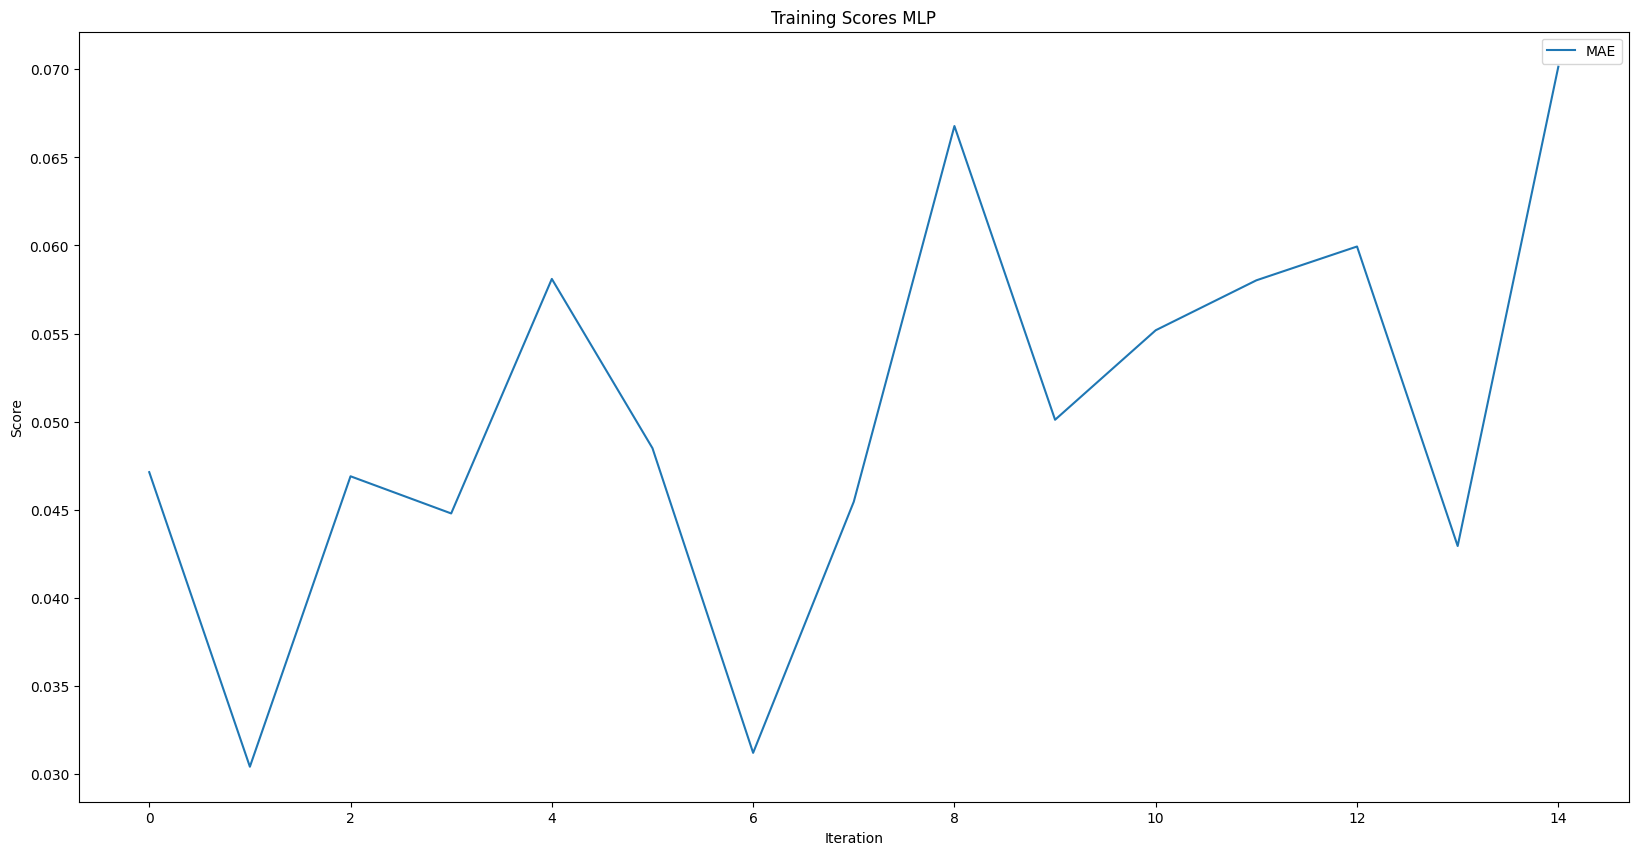

In [20]:
#Plot train vs validation
plt.figure(figsize=(20,10))
#plt.plot(testResDataFrame['R2Score'])
plt.plot(testResDataFrame['MAE'])
#plt.plot(testResDataFrame['MSE'])
plt.title('Training Scores MLP')
plt.ylabel('Score')
plt.xlabel('Iteration')
plt.legend(['MAE'], loc='upper right')
plt.show()

In [21]:
# Determine the IDX value where the MAE is smallest
minMaeIDX = testResDataFrame.loc[testResDataFrame['MAE']==testResDataFrame['MAE'].min()].index[0]

In [22]:
testResDataFrame.iloc[minMaeIDX]

HiddenLayers                                                        1
R2Score                                                      0.999016
MAE                                                          0.030408
MSE                                                          0.001135
MAPE                                                         0.070947
model               MLPMLasp(\n  (net): Sequential(\n    (0): Line...
TrainLoses          [1.0115268230438232, 0.9764190912246704, 0.942...
TestLoses           [1.16988205909729, 1.1316838264465332, 1.09475...
TrainPredictions    [[249.61725173694919], [108.76981501068141], [...
Name: 1, dtype: object

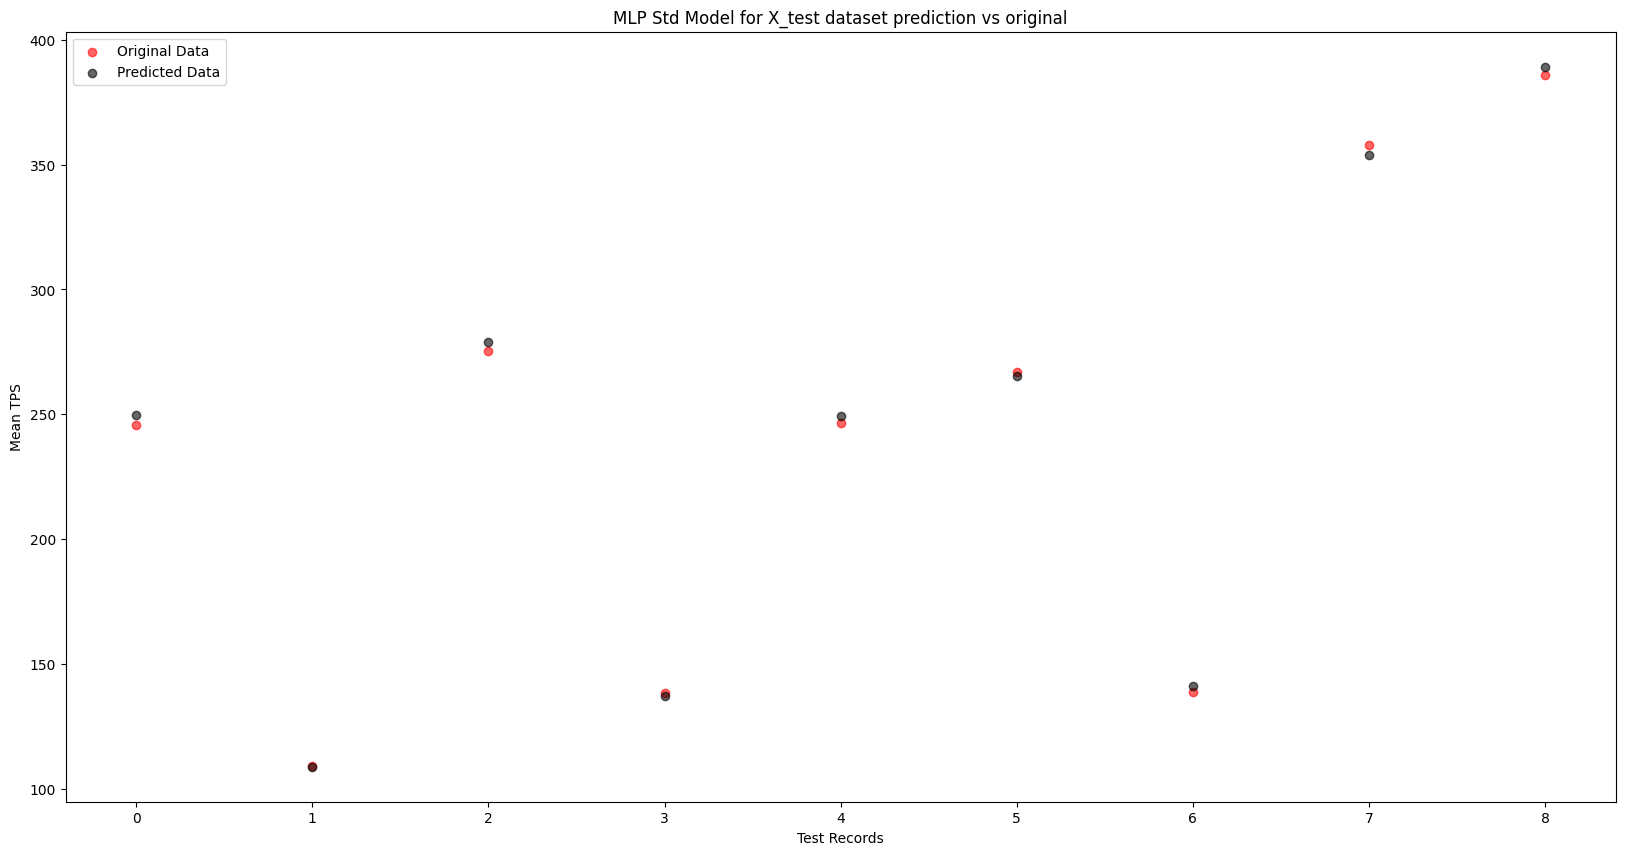

In [23]:
y_pred_MLP_std = testResDataFrame['TrainPredictions'][minMaeIDX]
# Plot prediction vs original
plt.figure(figsize=(20,10))
plt.scatter(range(y_test.shape[0]),y_test,label="Original Data", alpha=0.6, c='red')
plt.scatter(range(y_pred_MLP_std.shape[0]),y_pred_MLP_std,label="Predicted Data", 
            alpha=0.6, c='black')
plt.ylabel('Mean TPS')
plt.xlabel('Test Records')
plt.title('MLP Std Model for X_test dataset prediction vs original')
plt.legend()
plt.show()

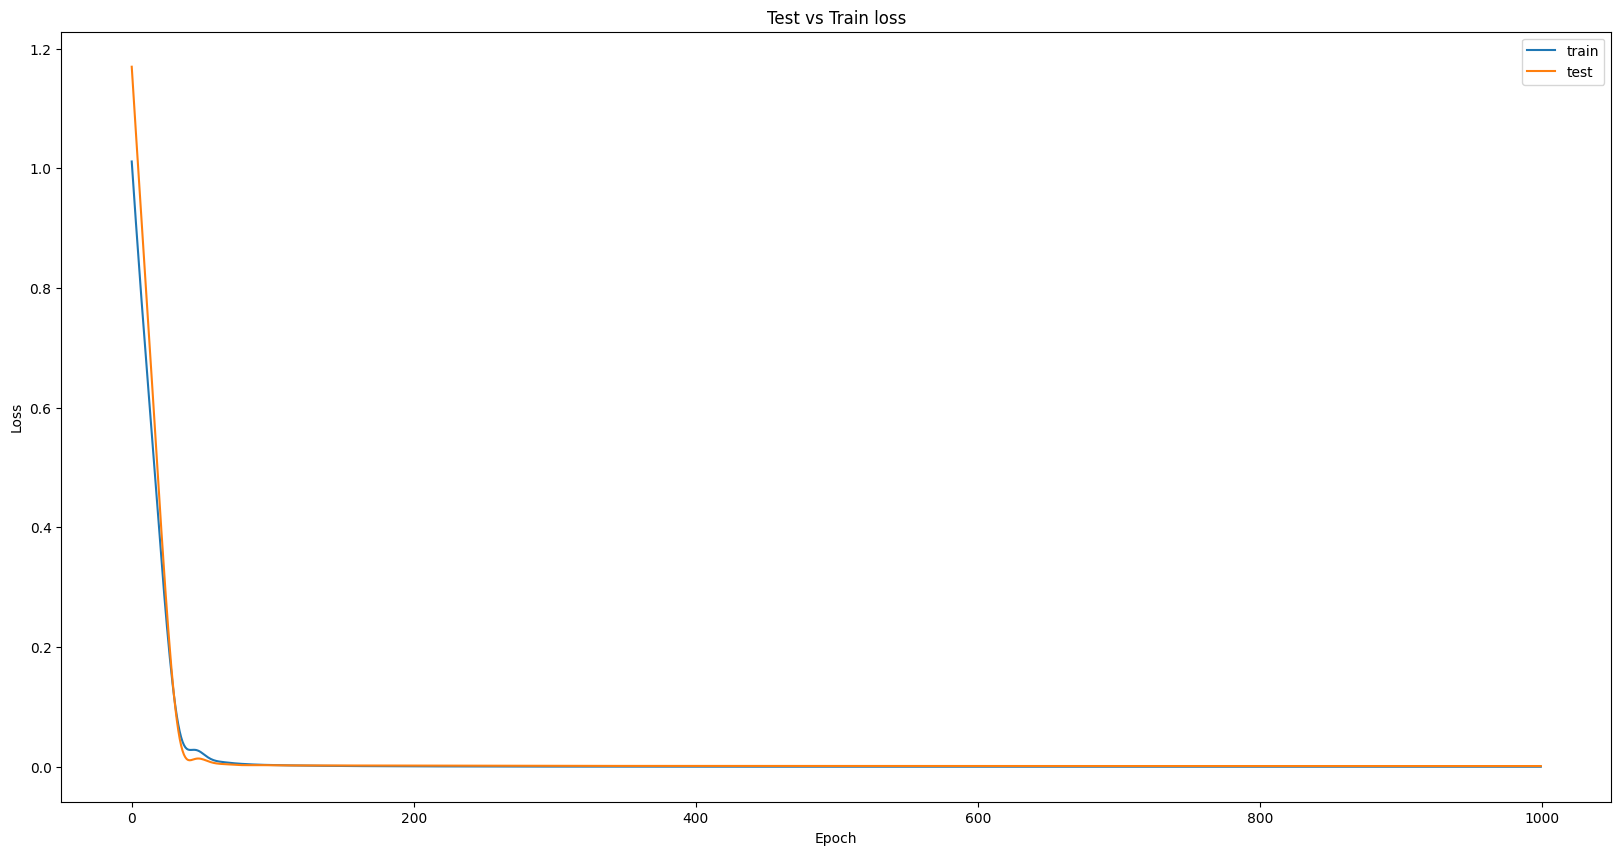

In [24]:
train_loses = testResDataFrame['TrainLoses'][minMaeIDX]
test_loses = testResDataFrame['TestLoses'][minMaeIDX]
#Plot train vs validation
plt.figure(figsize=(20,10))
plt.plot(train_loses)
plt.plot(test_loses)
plt.title('Test vs Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
MLFLOW_URI='http://mlflow-server.mlflow-strangiato.svc.cluster.local:8080/'
#MLFLOW_URI='http://localhost:8080/'

In [26]:
import os
os.environ["RAY_IGNORE_UNHANDLED_ERRORS"] = "1"

In [27]:
import logging
import ray

In [28]:
ray_endpoint = 'ray://raycluster-complete-head-svc.raycluster.svc.cluster.local:10001'

In [29]:
ray.shutdown()

In [30]:
ray.init(address=ray_endpoint, logging_level=logging.ERROR, log_to_driver=False)
#ray.init(logging_level=logging.ERROR, log_to_driver=False)

Python version:,3.11.6
Ray version:,2.9.0
Dashboard:,http://127.0.0.1:8265


In [31]:
import onnx
import onnxruntime

In [32]:
import mlflow

In [33]:
from ray.air.integrations.mlflow import setup_mlflow

In [34]:
@ray.remote
def createRemoteModel(inputSize, layerSize, hiddenSize, 
                y_train, X_train, y_test, X_test, 
                targetScaler, labelSet):

    mlflow_exp_name = f'mlasp-1-{labelSet}-{hiddenSize}'
    mlflow_ray_config = None
    mlflow_ray = setup_mlflow(config=mlflow_ray_config,
                              tracking_uri=MLFLOW_URI,
                              registry_uri=MLFLOW_URI,
                              create_experiment_if_not_exists=True,
                              rank_zero_only=False,
                             experiment_name=mlflow_exp_name)
    
    print(f'Create and training model with {hiddenSize} hidden layers using layer size = {layerSize} on set = {labelSet}.\n')
    model = MLPMLasp(inputSize, layerSize, hiddenSize, 1)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_loses = np.zeros(epochs)
    test_loses = np.zeros(epochs)

    for epoch in range(epochs):
        #forward and get a prediction
        y_pred_train = model.forward(X_train)
        #calculate the loss
        loss = criterion(y_pred_train, y_train)
        train_loses[epoch] = loss

        #perform backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #save the test loss if you want to compare train vs test scores
        y_eval = model.forward(X_test)
        test_loss = criterion(y_eval, y_test)
        test_loses[epoch] = test_loss

    with torch.no_grad():
        y_pred_scaled = model.forward(X_test)
    
    #Evaluate metrics
    y_pred = targetScaler.inverse_transform(y_pred_scaled)
    y_test_orig = targetScaler.inverse_transform(y_test)
    r2_score = metrics.r2_score(y_test, y_pred_scaled)
    mae = metrics.mean_absolute_error(y_test, y_pred_scaled)
    mse = metrics.mean_squared_error(y_test, y_pred_scaled)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred_scaled)
    
    row = [i, r2_score, mae, mse, mape, model, train_loses, test_loses, y_pred]
    
    fig=plt.figure(figsize=(20,10))
    plt.scatter(range(y_test_orig.shape[0]),y_test_orig,label="Original Data", alpha=0.6, c='red')
    plt.scatter(range(y_pred.shape[0]),y_pred,label="Predicted Data", 
                alpha=0.6, c='black')
    plt.ylabel('Mean TPS')
    plt.xlabel('Test Records')
    plt.title('MLP StdScaler Model for X_test dataset prediction vs original')
    plt.legend()    

    mlflow_ray.log_figure(fig,f"{mlflow_exp_name}.png")
    
    mlflow_ray.log_param("batch_size", 32)
    mlflow_ray.log_param("layer_size", layerSize)
    mlflow_ray.log_param("hidden_layers", loops)
    mlflow_ray.log_param("activation_function", "relu")
    mlflow_ray.log_param("dense_kernel_initializer", "torchnormal")
    mlflow_ray.log_param("epochs", epochs)
    mlflow_ray.log_param("learning_rate", 0.001)
    mlflow_ray.log_param("optimizer", "adam")

    mlflow_ray.log_metric("mae", mae)
    mlflow_ray.log_metric("mse", mse)
    mlflow_ray.log_metric("mape", mape)
    mlflow_ray.log_metric("r2_score", r2_score)

    model_onnx = torch.onnx.dynamo_export(model, X_train[0])
    mlflow_ray.onnx.log_model(model_onnx.model_proto, f"model-{mlflow_exp_name}")

    row = [hiddenSize, r2_score, mae, mse, mape]
    del(model)

    return row

In [35]:
%%time

testResDataFrame2 = []
layerSize = 64
loops = 15

for i in range(loops):
    rowResult = createRemoteModel.remote(inputSize, layerSize, i, 
                        y_train_scaled, X_train_scaled,
                        y_test_scaled, X_test_scaled, 
                        targetStdScaler, labelSet='all_ray')
    testResDataFrame2.append(rowResult)

CPU times: user 21.6 ms, sys: 6.76 ms, total: 28.4 ms
Wall time: 18.9 ms


In [36]:
testResDataFrame2

[ObjectRef(c8ef45ccd0112571ffffffffffffffffffffffff0100000001000000),
 ObjectRef(16310a0f0a45af5cffffffffffffffffffffffff0100000001000000),
 ObjectRef(c2668a65bda616c1ffffffffffffffffffffffff0100000001000000),
 ObjectRef(32d950ec0ccf9d2affffffffffffffffffffffff0100000001000000),
 ObjectRef(e0dc174c83599034ffffffffffffffffffffffff0100000001000000),
 ObjectRef(f4402ec78d3a2607ffffffffffffffffffffffff0100000001000000),
 ObjectRef(f91b78d7db9a6593ffffffffffffffffffffffff0100000001000000),
 ObjectRef(82891771158d68c1ffffffffffffffffffffffff0100000001000000),
 ObjectRef(8849b62d89cb30f9ffffffffffffffffffffffff0100000001000000),
 ObjectRef(80e22aed7718a125ffffffffffffffffffffffff0100000001000000),
 ObjectRef(359ec6ce30d3ca2dffffffffffffffffffffffff0100000001000000),
 ObjectRef(1e8ff6d236132784ffffffffffffffffffffffff0100000001000000),
 ObjectRef(85748392bcd969ccffffffffffffffffffffffff0100000001000000),
 ObjectRef(d695f922effe6d99ffffffffffffffffffffffff0100000001000000),
 ObjectRef(2751d6954

In [37]:
%%time

tResDF2 = ray.get(testResDataFrame2)

CPU times: user 22.4 ms, sys: 13.7 ms, total: 36.1 ms
Wall time: 8.74 s


In [38]:
ray.shutdown()

In [39]:
colList2=colList.copy()

In [40]:
df = pd.DataFrame(tResDF2, columns=colList2[0:5])

In [41]:
df

,HiddenLayers,R2Score,MAE,MSE,MAPE
0,0,0.996570,0.050200,0.003956,0.089772
1,1,0.996330,0.057317,0.004232,0.127071
2,2,0.992061,0.065260,0.009155,0.122597
3,3,0.995105,0.056847,0.005644,0.126042
4,4,0.990530,0.083588,0.010921,0.181601
5,5,0.997546,0.038416,0.002830,0.048340
6,6,0.996571,0.042661,0.003954,0.088185
7,7,0.997321,0.040987,0.003090,0.079195
8,8,0.997425,0.044777,0.002969,0.087702
9,9,0.995643,0.058798,0.005025,0.086857


In [42]:
minMaeIDX_ray = df.loc[df['MAE']==df['MAE'].min()].index[0]

In [43]:
df.iloc[minMaeIDX_ray]

HiddenLayers    13.000000
R2Score          0.997888
MAE              0.034172
MSE              0.002435
MAPE             0.062971
Name: 13, dtype: float64

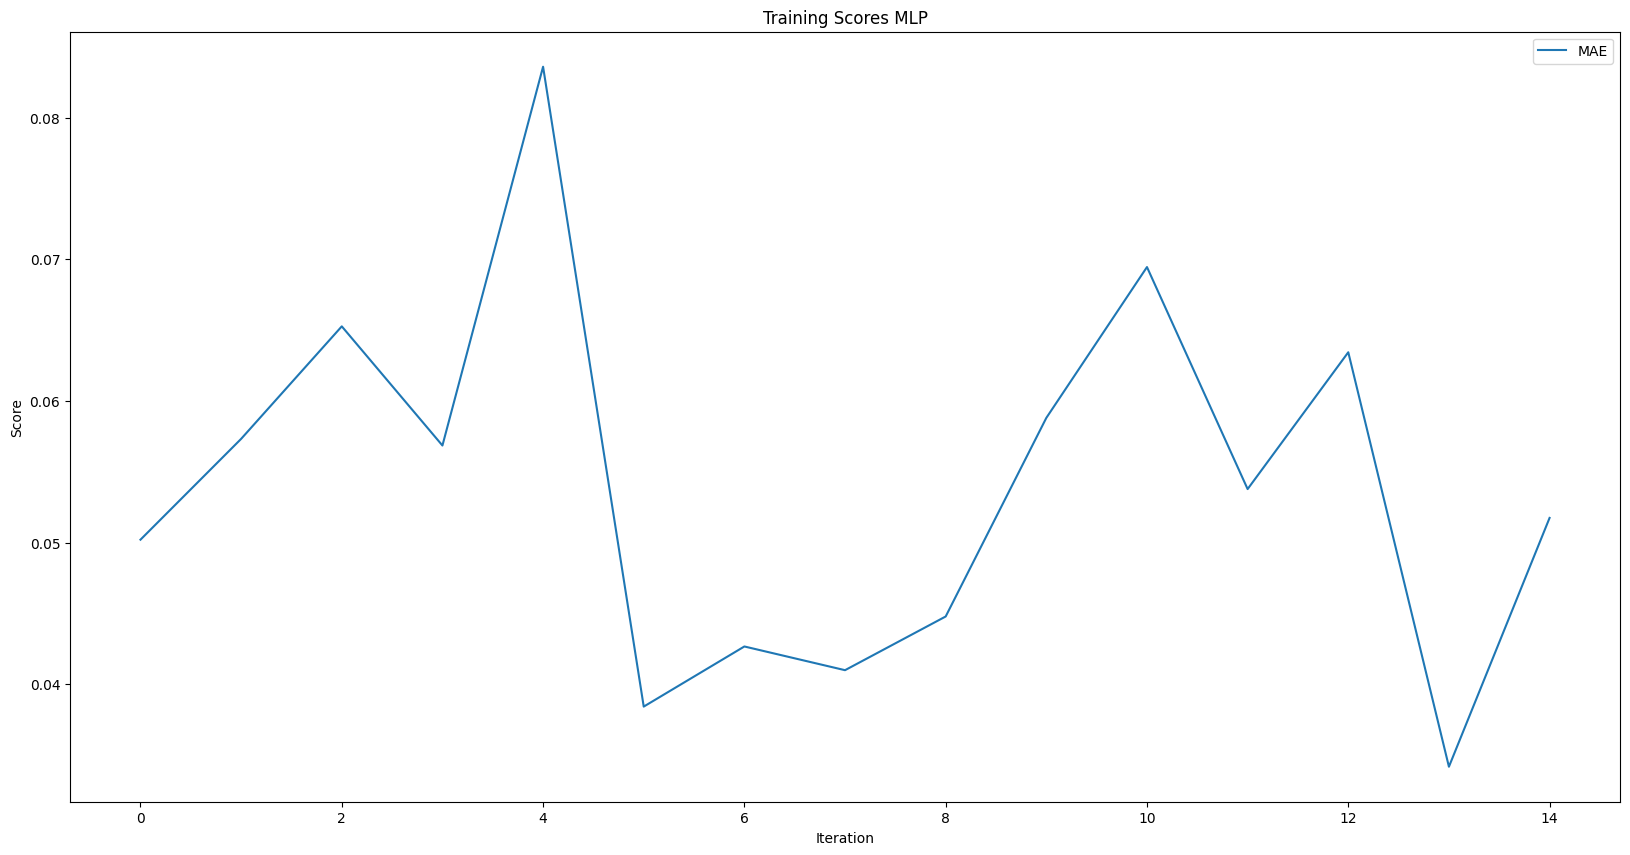

In [44]:
#Plot train vs validation
plt.figure(figsize=(20,10))
#plt.plot(df['R2Score'])
plt.plot(df['MAE'])
#plt.plot(df['MSE'])
plt.title('Training Scores MLP')
plt.ylabel('Score')
plt.xlabel('Iteration')
plt.legend(['MAE'], loc='upper right')
plt.show()

In [45]:
X_test.columns

Index(['asyncResp', 'asyncRespThreads', 'cThreads', 'jacptQSize',
       'jacptThreads', 'ltTargetSize', 'numConnections', 'timeoutSeconds'],
      dtype='object')

In [46]:
data.head(1)

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,timeoutSeconds
DateTime,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,5.0


In [47]:
record = [[True, 21, 277, 1712, 262, 7, 31, 5]]

In [48]:
test_rec = stdScaler.transform(record)

In [49]:
test_rec = torch.FloatTensor(test_rec)

In [50]:
test_rec

tensor([[ 0.3482, -0.1661,  1.1439, -0.5367,  1.1439, -0.2901,  0.9050,  0.3004]])

In [51]:
ml_model = testResDataFrame['model'][minMaeIDX]

In [52]:
with torch.no_grad():
    y_pred_scaled = ml_model.forward(test_rec)

y_pred = targetStdScaler.inverse_transform(y_pred_scaled)
y_pred

array([[307.02674017]])

### Save the scalers for the inference calls

In [53]:
joblib.dump(targetStdScaler,'target_scaler.pkl')

['target_scaler.pkl']

In [54]:
joblib.dump(stdScaler,'standard_scaler.pkl')

['standard_scaler.pkl']

In [55]:
torch.onnx.export(ml_model, test_rec, 'torch_mlasp.onnx')